In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print('✓ Libraries imported')

✓ Libraries imported


In [34]:
# Load eye-tracking features
df_eye = pd.read_csv('./preprocessed/eye_tracking_features.csv')

print(f'Loaded {len(df_eye)} trials')
print(f'\nColumns: {list(df_eye.columns)}')
print(f'\nSessions: {sorted(df_eye["session_id"].unique())}')
print(f'Alignment conditions: {sorted(df_eye["alignment"].unique())}')

Loaded 45 trials

Columns: ['session_id', 'trial_idx', 'trial_n', 'alignment', 'duration', 'roi_coverage', 'fixation_count', 'fixation_duration_mean', 'fixation_duration_total', 'fixation_dispersion_x', 'fixation_dispersion_y', 'time_to_first_fixation', 'saccade_count', 'saccade_amplitude_mean', 'saccade_amplitude_max', 'saccade_velocity_mean', 'pupil_size_mean', 'pupil_size_std']

Sessions: [np.int64(0), np.int64(1), np.int64(4)]
Alignment conditions: ['unknown']


## 2. Data Preparation

In [12]:
# Display first few rows
print('First 5 trials:')
df_eye.head()

First 5 trials:


,session_id,trial_idx,trial_n,alignment,duration,roi_coverage,fixation_count,fixation_duration_mean,fixation_duration_total,fixation_dispersion_x,fixation_dispersion_y,time_to_first_fixation,saccade_count,saccade_amplitude_mean,saccade_amplitude_max,saccade_velocity_mean,pupil_size_mean,pupil_size_std
0,0,0,4.0,unknown,30.0,95.263333,9,0.153667,1.383,0.0,0.0,1.841,23,544.212534,1238.356242,719429.274695,913.345850,234.332810
1,0,1,9.0,unknown,30.0,88.396667,4,0.684750,2.739,0.0,0.0,6.712,22,366.877306,1227.042306,472025.631375,935.839917,362.912011
2,0,2,14.0,unknown,30.0,90.400000,9,0.306222,2.756,0.0,0.0,1.761,25,614.150307,1316.037879,660976.029758,934.635133,314.288157
3,0,3,21.0,unknown,30.0,97.473333,5,0.148600,0.743,0.0,0.0,5.154,10,488.757687,1066.898554,787505.051984,933.165583,254.860268
4,0,4,22.0,unknown,30.0,96.376667,2,0.494000,0.988,0.0,0.0,1.759,9,575.169363,1891.562284,962655.942502,932.702267,249.862712


In [13]:
# Check for missing values
print('Missing values per column:')
missing = df_eye.isnull().sum()
print(missing[missing > 0])

# Summary statistics
print('\nSummary statistics:')
df_eye.describe()

Missing values per column:
time_to_first_fixation    1
dtype: int64

Summary statistics:


,session_id,trial_idx,trial_n,duration,roi_coverage,fixation_count,fixation_duration_mean,fixation_duration_total,fixation_dispersion_x,fixation_dispersion_y,time_to_first_fixation,saccade_count,saccade_amplitude_mean,saccade_amplitude_max,saccade_velocity_mean,pupil_size_mean,pupil_size_std
count,45.000000,45.000000,45.000000,45.0,45.000000,45.000000,45.000000,45.000000,45.0,45.0,44.000000,45.000000,45.000000,45.000000,4.500000e+01,45.000000,45.000000
mean,1.644444,7.155556,26.222222,30.0,56.907481,8.911111,4.193726,12.404222,0.0,0.0,1.162341,40.800000,311.146816,1157.771953,5.378587e+05,573.218967,412.672338
std,1.653585,4.646384,14.636332,0.0,32.504245,5.554778,8.557874,9.910468,0.0,0.0,1.692863,30.579702,173.178296,532.736949,2.710496e+05,329.199051,183.402330
min,0.000000,0.000000,0.000000,30.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.001000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,3.000000,14.000000,30.0,35.463333,4.000000,0.491560,3.052000,0.0,0.0,0.001000,19.000000,219.793453,849.412322,3.888599e+05,352.997783,330.762431
50%,1.000000,7.000000,26.000000,30.0,66.143333,9.000000,0.706364,9.672000,0.0,0.0,0.491500,42.000000,274.230439,1227.042306,5.741754e+05,629.055850,448.984790
75%,4.000000,11.000000,38.000000,30.0,86.873333,12.000000,1.922778,19.146000,0.0,0.0,1.781000,58.000000,396.658130,1429.418330,7.253774e+05,828.784300,481.189657
max,4.000000,17.000000,49.000000,30.0,100.000000,25.000000,29.999000,29.999000,0.0,0.0,6.712000,147.000000,744.860806,2479.450146,1.304231e+06,1100.080800,912.370500


In [36]:
# Create rating categories (Low, Medium, High)
# Assuming alignment is already categorized as 'low', 'medium', 'high'
# If you have numeric ratings, uncomment and adapt the binning code below:

# def score_mapper(score, bins=3):
#     """Map continuous score to bins"""
#     w = 100 / bins
#     for i in range(bins):
#         if i * w <= score <= (i + 1) * w:
#             return i
#     return np.nan

# df_eye['Rating_Bin'] = df_eye['rating_score'].apply(lambda x: score_mapper(x, bins=3))
# df_eye['Rating_Category'] = df_eye['Rating_Bin'].map({0: 'Low', 1: 'Medium', 2: 'High'})

# For now, use alignment as category
df_eye['Rating_Category'] = df_eye['alignment'].str.capitalize()

print('Rating category distribution:')
print(df_eye['Rating_Category'].value_counts())
print(f'\nTrials per session:')
print(df_eye.groupby('session_id')['Rating_Category'].value_counts())

Rating category distribution:
Rating_Category
Unknown    45
Name: count, dtype: int64

Trials per session:
session_id  Rating_Category
0           Unknown            13
1           Unknown            18
4           Unknown            14
Name: count, dtype: int64


In [39]:
# Convert categorical variables
present = sorted(df_eye['Rating_Category'].dropna().unique().tolist())
base_order = ['Low', 'Medium', 'High']
order = [c for c in base_order if c in present] + [c for c in present if c not in base_order]
if not order:
    # If nothing present (e.g., all NaN), rebuild from alignment values
    df_eye['Rating_Category'] = df_eye['alignment'].astype(str).str.capitalize()
    present = sorted(df_eye['Rating_Category'].dropna().unique().tolist())
    order = [c for c in base_order if c in present] + [c for c in present if c not in base_order]

df_eye['Rating_Category'] = pd.Categorical(df_eye['Rating_Category'], categories=order, ordered=True)
df_eye['session_id'] = df_eye['session_id'].astype('category')
df_eye['trial_idx'] = df_eye['trial_idx'].astype('category')

print('✓ Data prepared for analysis')
print(f'\nFinal dataset: {len(df_eye)} trials')
print(f'Sessions: {df_eye["session_id"].nunique()}')
print(f'Categories: {df_eye["Rating_Category"].cat.categories.tolist()}')

✓ Data prepared for analysis

Final dataset: 45 trials
Sessions: 3
Categories: ['Unknown']


## 3. Exploratory Visualizations

In [41]:
# Helper to draw category boxplots with matplotlib (avoids seaborn bug)
from typing import List

def draw_category_boxplot(df, metric: str, ylabel: str, title: str, filename: str,
                          categories: List[str] = ['Low','Medium','High'],
                          colors: dict = {'Low':'red','Medium':'orange','High':'green'}):
    # Use provided order if present; otherwise fallback to whatever categories exist
    cats_present = [c for c in categories if c in df['Rating_Category'].unique()]
    if not cats_present:
        cats_present = [c for c in df['Rating_Category'].dropna().unique().tolist()]
        if not cats_present:
            print('No categories present to plot.')
            return
    data = [df.loc[df['Rating_Category'] == c, metric].dropna() for c in cats_present]

    fig, ax = plt.subplots(figsize=(10,6))
    bp = ax.boxplot(data, labels=cats_present, patch_artist=True, widths=0.6)

    # Color boxes per category
    for patch, c in zip(bp['boxes'], cats_present):
        patch.set_facecolor(colors.get(c, '#7aa6c2'))
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(2)
    for whisker in bp['whiskers']:
        whisker.set_color('black')
    for cap in bp['caps']:
        cap.set_color('black')

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Rating Category', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, axis='y', alpha=0.3)

    Path('./figures').mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'\u2713 Saved to {filename}')

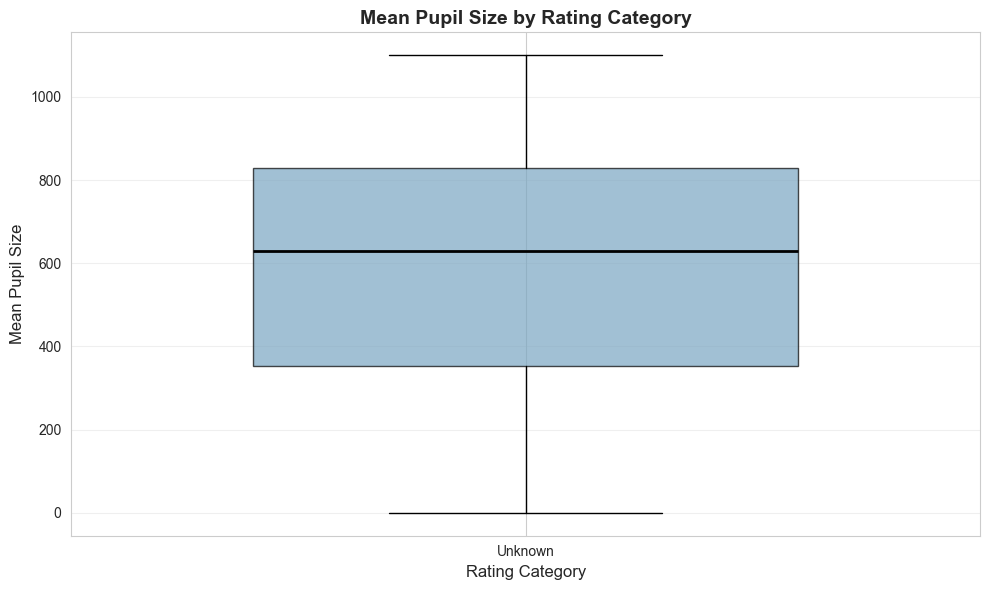

✓ Saved to ./figures/eye_stats_pupil_by_category.png


In [42]:
# Boxplot: Pupil size by rating category
draw_category_boxplot(
    df=df_eye,
    metric='pupil_size_mean',
    ylabel='Mean Pupil Size',
    title='Mean Pupil Size by Rating Category',
    filename='./figures/eye_stats_pupil_by_category.png'
)

In [22]:
# Boxplot: Fixation duration by rating category
draw_category_boxplot(
    df=df_eye,
    metric='fixation_duration_mean',
    ylabel='Fixation Duration (s)',
    title='Mean Fixation Duration by Rating Category',
    filename='./figures/eye_stats_fixation_by_category.png'
)

No categories present to plot.


In [24]:
# Boxplot: Saccade amplitude by rating category
draw_category_boxplot(
    df=df_eye,
    metric='saccade_amplitude_mean',
    ylabel='Saccade Amplitude (px)',
    title='Mean Saccade Amplitude by Rating Category',
    filename='./figures/eye_stats_saccade_by_category.png'
)

No categories present to plot.


## 4. Linear Mixed-Effects Models

We'll fit linear mixed-effects models (LMMs) to test the effect of Rating_Category on various eye-tracking metrics, accounting for random effects of participant (session_id) and trial.

In [ ]:
# Helper to fit MixedLM with graceful fallback when only one category exists

def fit_mixedlm_with_category(dep_var: str):
    cats = [c for c in df_eye['Rating_Category'].cat.categories if c in df_eye['Rating_Category'].unique()]
    if len(cats) < 2:
        print(f"Only one category present ({cats[0] if cats else 'None'}). Fitting intercept-only model.")
        formula = f"{dep_var} ~ 1"
    else:
        # C() ensures categorical treatment regardless of dtype
        formula = f"{dep_var} ~ C(Rating_Category)"
    try:
        model = smf.mixedlm(formula, df_eye, groups=df_eye["session_id"]).fit(reml=True)
        print(f"\nModel formula: {formula}")
        print(model.summary())
        print(f"\nAIC: {model.aic:.2f}")
        print(f"BIC: {model.bic:.2f}")
        return model
    except Exception as e:
        print(f"Model failed for {dep_var}: {e}")
        return None

### 4.1 Pupil Size Mean

In [25]:
print('='*80)
print('LINEAR MIXED MODEL: Pupil Size Mean')
print('='*80)

m1_pupil = fit_mixedlm_with_category('pupil_size_mean')


LINEAR MIXED MODEL: Pupil Size Mean
Model failed: zero-size array to reduction operation maximum which has no identity


In [26]:
# Simple model comparison isn't directly available in statsmodels like in R's lme4
# For now, we'll report AIC/BIC for model selection

if m1_pupil is not None:
    print('\n' + '='*80)
    print('MODEL SUMMARY: Pupil Size')
    print('='*80)
    print(f'AIC: {m1_pupil.aic:.2f}')
    print(f'BIC: {m1_pupil.bic:.2f}')
    print(f'Log-Likelihood: {m1_pupil.llf:.2f}')
    
    print('\nFixed Effects:')
    print(m1_pupil.fe_params)
    
    print('\nRandom Effects SD:')
    print(f'Session (Intercept): {np.sqrt(m1_pupil.cov_re.iloc[0,0]):.4f}')

### 4.2 Fixation Duration Mean

In [27]:
print('='*80)
print('LINEAR MIXED MODEL: Fixation Duration Mean')
print('='*80)

m1_fix = fit_mixedlm_with_category('fixation_duration_mean')


LINEAR MIXED MODEL: Fixation Duration Mean
Model failed: zero-size array to reduction operation maximum which has no identity


### 4.3 Saccade Amplitude Mean

In [28]:
print('='*80)
print('LINEAR MIXED MODEL: Saccade Amplitude Mean')
print('='*80)

m1_sacc = fit_mixedlm_with_category('saccade_amplitude_mean')


LINEAR MIXED MODEL: Saccade Amplitude Mean
Model failed: zero-size array to reduction operation maximum which has no identity


### 4.4 Saccade Count

In [29]:
print('='*80)
print('LINEAR MIXED MODEL: Saccade Count')
print('='*80)

m1_sacc_count = fit_mixedlm_with_category('saccade_count')


LINEAR MIXED MODEL: Saccade Count
Model failed: zero-size array to reduction operation maximum which has no identity


## 5. Summary of Results

In [30]:
# Create summary table of model fits
results = []

models = [
    ('Pupil Size Mean', m1_pupil),
    ('Fixation Duration Mean', m1_fix),
    ('Saccade Amplitude Mean', m1_sacc),
    ('Saccade Count', m1_sacc_count)
]

for name, model in models:
    if model is not None:
        results.append({
            'Dependent Variable': name,
            'AIC': f'{model.aic:.2f}',
            'BIC': f'{model.bic:.2f}',
            'Log-Likelihood': f'{model.llf:.2f}',
            'Converged': 'Yes'
        })
    else:
        results.append({
            'Dependent Variable': name,
            'AIC': 'N/A',
            'BIC': 'N/A',
            'Log-Likelihood': 'N/A',
            'Converged': 'No'
        })

df_results = pd.DataFrame(results)

print('\n' + '='*80)
print('MODEL COMPARISON SUMMARY')
print('='*80)
print(df_results.to_string(index=False))

# Save to CSV
df_results.to_csv('./results/eye_stats_model_summary.csv', index=False)
print('\n✓ Saved to ./results/eye_stats_model_summary.csv')


MODEL COMPARISON SUMMARY
    Dependent Variable AIC BIC Log-Likelihood Converged
       Pupil Size Mean N/A N/A            N/A        No
Fixation Duration Mean N/A N/A            N/A        No
Saccade Amplitude Mean N/A N/A            N/A        No
         Saccade Count N/A N/A            N/A        No

✓ Saved to ./results/eye_stats_model_summary.csv


## 6. Descriptive Statistics by Category

In [31]:
# Calculate descriptive statistics by rating category
metrics = ['pupil_size_mean', 'fixation_duration_mean', 'saccade_amplitude_mean', 'saccade_count']

desc_stats = df_eye.groupby('Rating_Category')[metrics].agg(['mean', 'std', 'count'])

print('\n' + '='*80)
print('DESCRIPTIVE STATISTICS BY RATING CATEGORY')
print('='*80)
print(desc_stats.round(3))

# Save to CSV
desc_stats.to_csv('./results/eye_stats_descriptives.csv')
print('\n✓ Saved to ./results/eye_stats_descriptives.csv')


DESCRIPTIVE STATISTICS BY RATING CATEGORY
                pupil_size_mean           fixation_duration_mean            \
                           mean std count                   mean std count   
Rating_Category                                                              
Low                         NaN NaN     0                    NaN NaN     0   
Medium                      NaN NaN     0                    NaN NaN     0   
High                        NaN NaN     0                    NaN NaN     0   

                saccade_amplitude_mean           saccade_count            
                                  mean std count          mean std count  
Rating_Category                                                           
Low                                NaN NaN     0           NaN NaN     0  
Medium                             NaN NaN     0           NaN NaN     0  
High                               NaN NaN     0           NaN NaN     0  

✓ Saved to ./results/eye_stats_descri

In [32]:
print('\n' + '='*80)
print('✅ STATISTICAL ANALYSIS COMPLETE')
print('='*80)
print('\nOutputs:')
print('  • Figures: ./figures/eye_stats_*.png')
print('  • Results: ./results/eye_stats_*.csv')
print(f'\nAnalyzed {len(df_eye)} trials from {df_eye["session_id"].nunique()} sessions')
print(f'Rating categories: {list(df_eye["Rating_Category"].unique())}')


✅ STATISTICAL ANALYSIS COMPLETE

Outputs:
  • Figures: ./figures/eye_stats_*.png
  • Results: ./results/eye_stats_*.csv

Analyzed 45 trials from 3 sessions
Rating categories: [nan]
